In [42]:
# ==========================
# 🩺 Heart Disease Prediction Notebook
# ==========================

# 📌 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, 
    ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve


In [43]:
#loading data
data = pd.read_csv(r"heart_cleveland_upload.csv")




In [44]:
data.describe

<bound method NDFrame.describe of      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     69    1   0       160   234    1        2      131      0      0.1   
1     69    0   0       140   239    0        0      151      0      1.8   
2     66    0   0       150   226    0        0      114      0      2.6   
3     65    1   0       138   282    1        2      174      0      1.4   
4     64    1   0       110   211    0        2      144      1      1.8   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
292   40    1   3       152   223    0        0      181      0      0.0   
293   39    1   3       118   219    0        0      140      0      1.2   
294   35    1   3       120   198    0        0      130      1      1.6   
295   35    0   3       138   183    0        0      182      0      1.4   
296   35    1   3       126   282    0        2      156      1      0.0   

     slope  ca  thal  condition  
0        1   1     

In [45]:
print(data.isnull().sum())

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64


In [46]:
data.columns


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')

In [47]:
data.dtypes

age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
condition      int64
dtype: object

In [48]:
# ==========================
# 📌 3. Add Cardiac Indicators
# ==========================

# Age Groups
def age_group(age):
    if age < 40: return "Young"
    elif age < 60: return "Middle"
    else: return "Old"

data["age_group"] = data["age"].apply(age_group)

# Blood Pressure Category
def bp_category(bp):
    if bp < 120: return "Normal"
    elif bp < 130: return "Elevated"
    elif bp < 140: return "Hypertension Stage 1"
    else: return "Hypertension Stage 2"

data["bp_category"] = data["trestbps"].apply(bp_category)

# Cholesterol Risk
def chol_risk(chol):
    if chol < 200: return "Desirable"
    elif chol < 240: return "Borderline"
    else: return "High"

data["chol_risk"] = data["chol"].apply(chol_risk)

# Heart Rate Reserve (HRR)
data["HRR"] = (220 - data["age"]) - data["thalach"]

# Oldpeak Risk
def oldpeak_risk(op):
    if op < 1: return "Low"
    elif op < 2: return "Moderate"
    else: return "High"

data["oldpeak_risk"] = data["oldpeak"].apply(oldpeak_risk)

# Composite Risk Score
data["risk_score"] = (
    (data["age"]/100) + 
    (data["trestbps"]/200) + 
    (data["chol"]/300) + 
    (data["oldpeak"]/5)
)

# Encode categorical indicators
for col in ["age_group", "bp_category", "chol_risk", "oldpeak_risk"]:
    data[col] = LabelEncoder().fit_transform(data[col])

In [49]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=data['sex'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=data['condition'].value_counts(), name="condition"),
              1, 2)


fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and condition Distributions",

    annotations=[dict(text='Gender', x=0.19, y=0.5, font_size=20, showarrow=False),
                 dict(text='condition', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

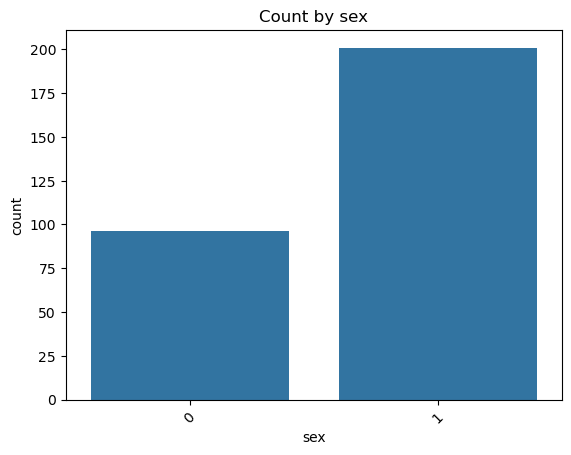

In [50]:

sns.countplot(x='sex', data=data)
plt.title("Count by sex"); plt.xticks(rotation=45); plt.show()
#male=1 , female=0

<Axes: xlabel='trestbps', ylabel='Count'>

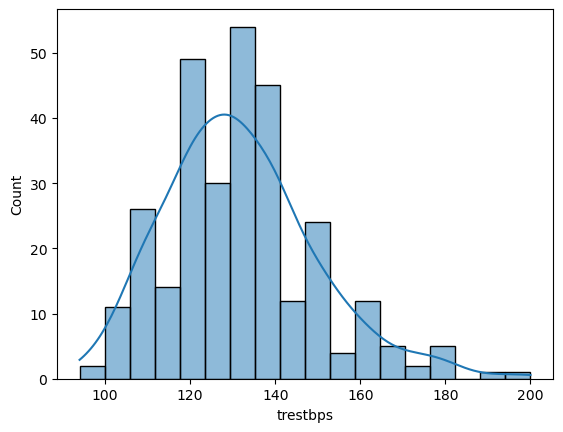

In [51]:
sns.histplot(data["trestbps"], kde=True)

<Axes: xlabel='chol', ylabel='Count'>

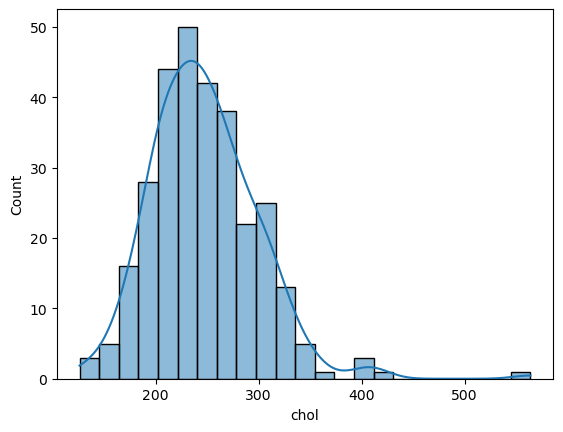

In [52]:
sns.histplot(data["chol"], kde=True)

<Axes: xlabel='thalach', ylabel='Count'>

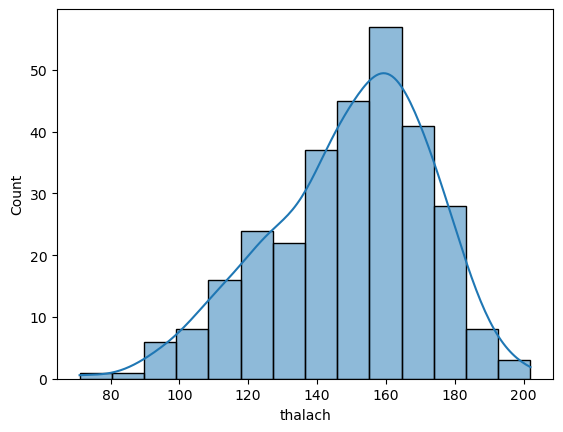

In [53]:
sns.histplot(data["thalach"], kde=True)

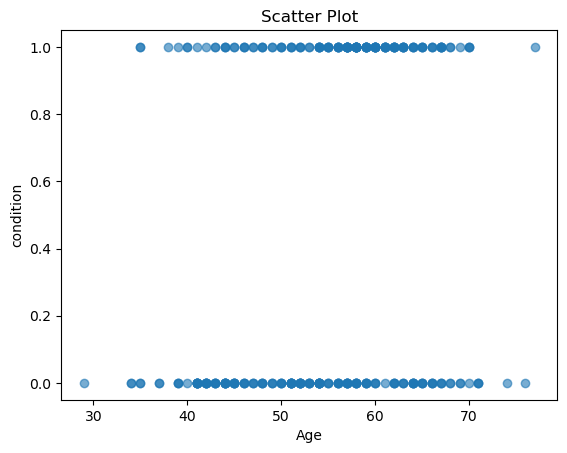

In [54]:
plt.scatter(data['age'], data['condition'], alpha=0.6)
plt.xlabel("Age"); plt.ylabel("condition"); plt.title("Scatter Plot"); plt.show()

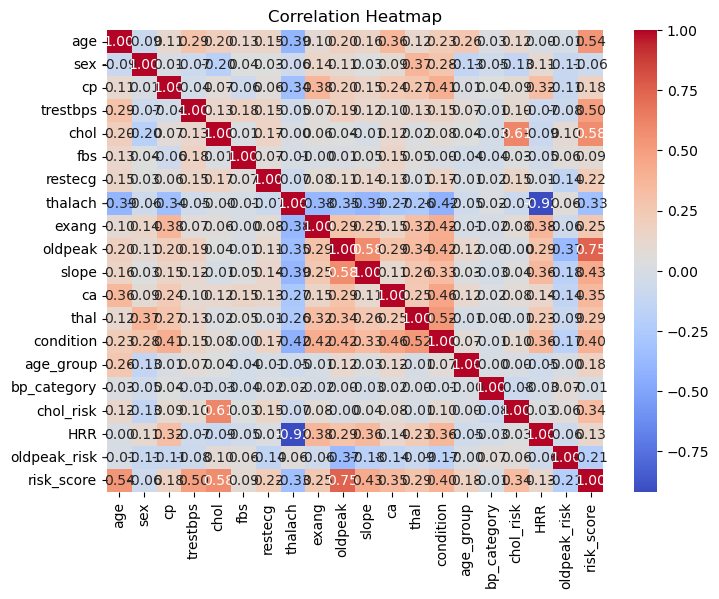

In [55]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [56]:
#Modeling
x=data.drop(["condition"] , axis=1)
y=data["condition"]
feature_names = x.columns.tolist()
print("Feature names:", feature_names)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train , x_test , y_train , y_test =train_test_split(x ,y , test_size=0.2,random_state=42 , stratify=y)
print(x_train.shape , y_train.shape) , x_test , y_test
from sklearn.metrics import (RocCurveDisplay, PrecisionRecallDisplay,
                             ConfusionMatrixDisplay,
                             mean_squared_error, r2_score)

Feature names: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'age_group', 'bp_category', 'chol_risk', 'HRR', 'oldpeak_risk', 'risk_score']
(237, 19) (237,)


RandomForestClassifier  accuracy score is 0.8607594936708861 


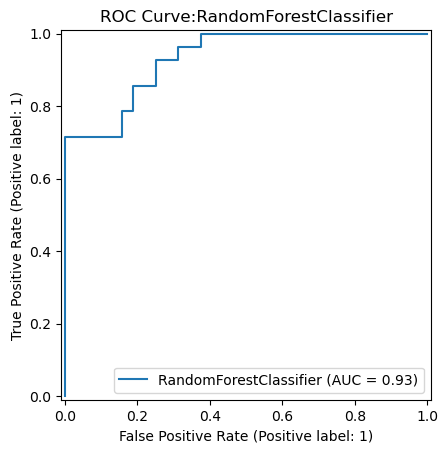

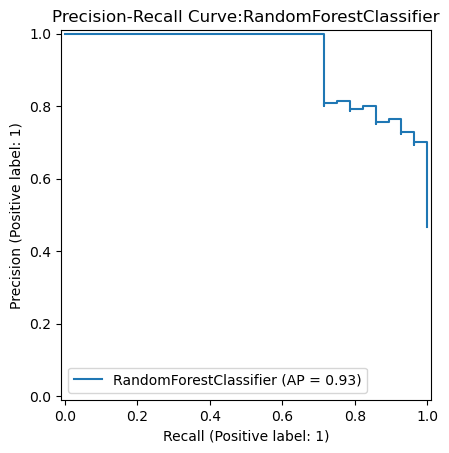

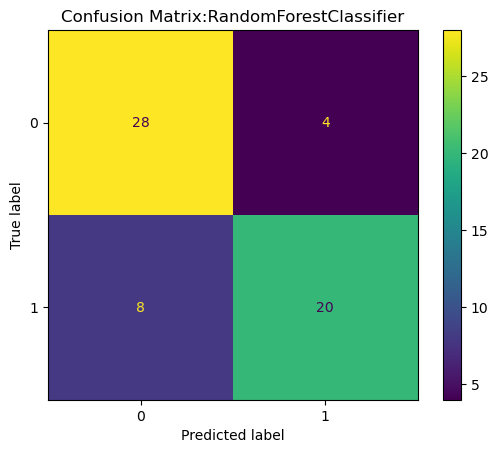

GradientBoostingClassifier  accuracy score is 1.0 


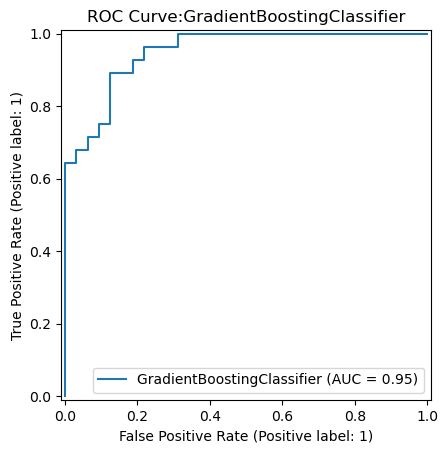

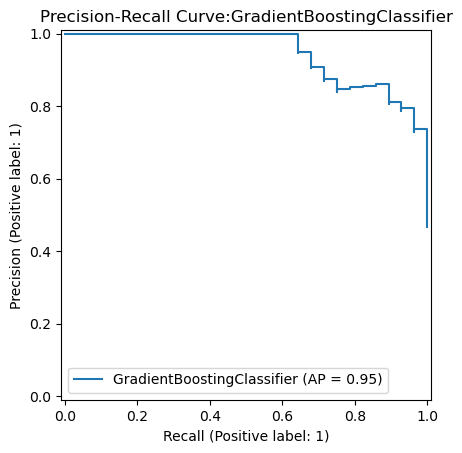

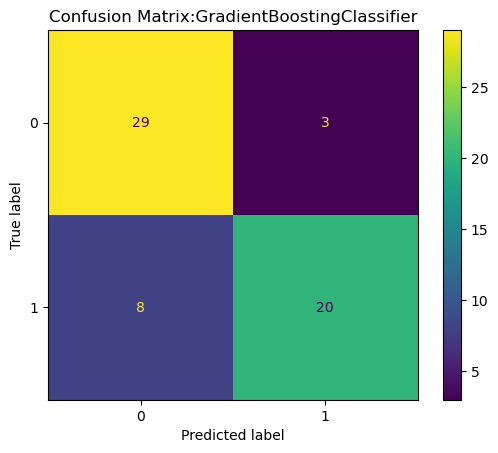

LogisticRegression  accuracy score is 0.8438818565400844 


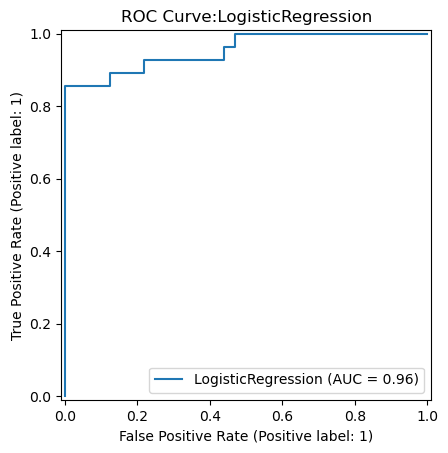

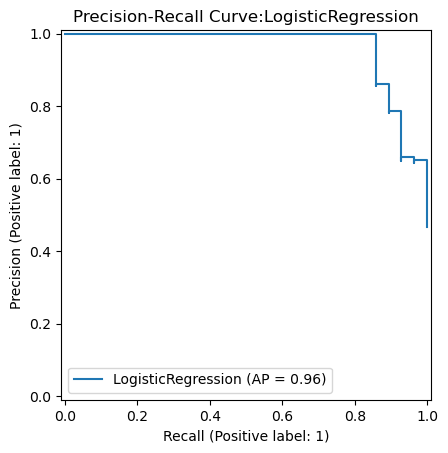

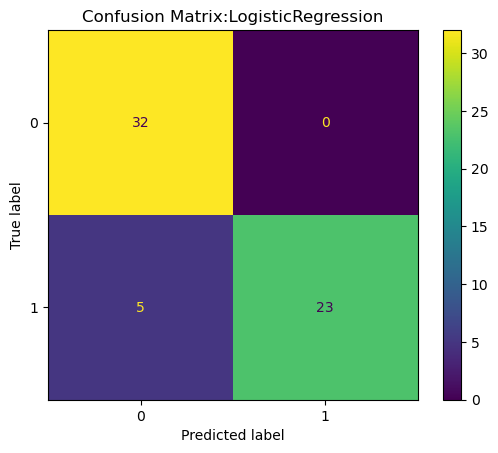

In [57]:
modeles={"RandomForestClassifier":RandomForestClassifier( n_estimators=500,       
    max_depth=6,             
    min_samples_split=50,   
    min_samples_leaf=20,    
    max_features=0.3,       
    class_weight="balanced", 
    random_state=42) , 
         "GradientBoostingClassifier":GradientBoostingClassifier() ,
         "LogisticRegression" :LogisticRegression()}

for name,a in modeles.items():
    a.fit(x_train,y_train)
    y_pre=a.predict(x_train)

    accuracy=accuracy_score(y_train, y_pre)
    print(f"{name}  accuracy score is {accuracy} ")
    RocCurveDisplay.from_estimator(a, x_test, y_test)
    plt.title(f"ROC Curve:{name}"); plt.show()
    PrecisionRecallDisplay.from_estimator(a, x_test, y_test)
    plt.title(f"Precision-Recall Curve:{name}"); plt.show()
    ConfusionMatrixDisplay.from_estimator(a, x_test, y_test)
    plt.title(f"Confusion Matrix:{name}"); plt.show()
    

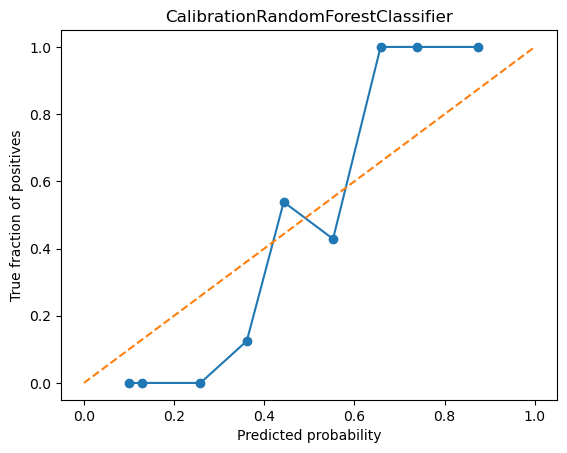

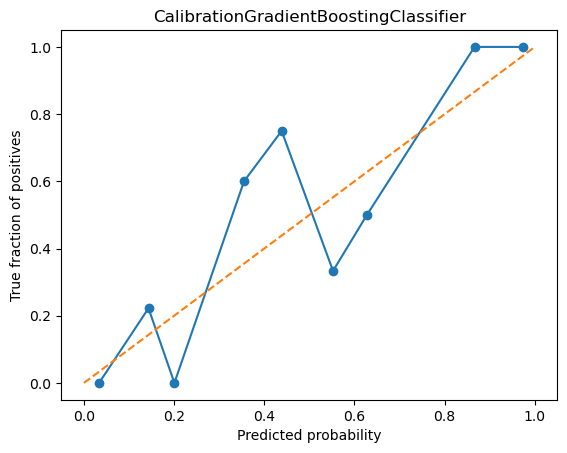

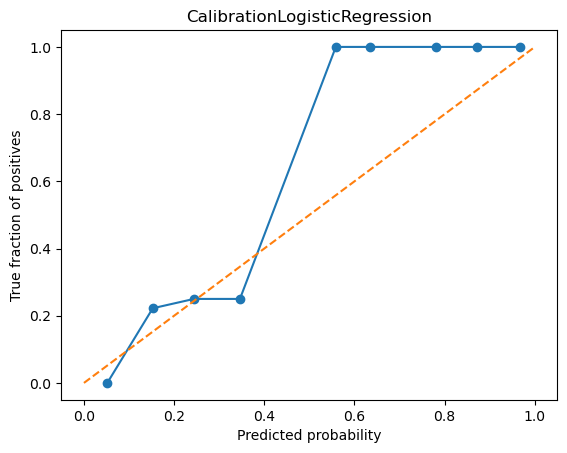

In [58]:

# Calibration Curve
for name,a in modeles.items():
    prob_pos = a.predict_proba(x_test)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10, strategy='uniform')
    plt.plot(mean_pred, frac_pos, marker='o'); plt.plot([0,1],[0,1],'--')
    plt.xlabel('Predicted probability'); plt.ylabel('True fraction of positives'); plt.title(f'Calibration{name}'); plt.show()

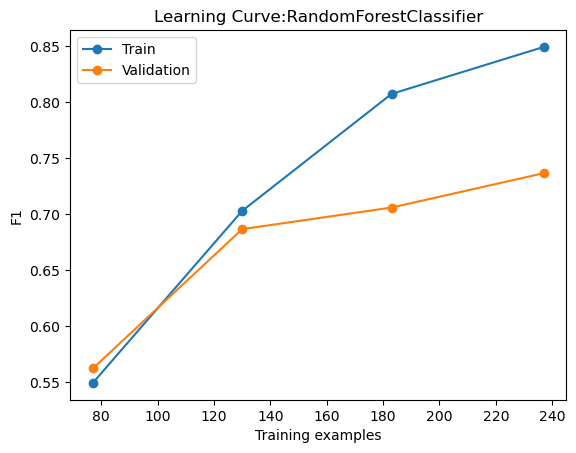

c:\Users\moham\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\moham\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\moham\anaconda3\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\moham\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py", line 669, in fit
    y = self._encode_y(y=y

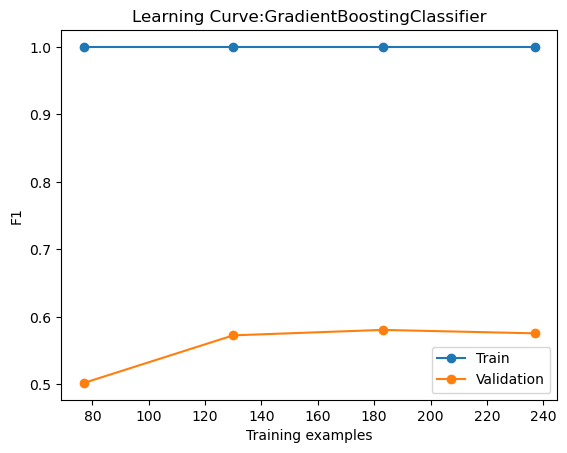

c:\Users\moham\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\moham\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\moham\anaconda3\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\moham\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1335, in fit
    raise Value

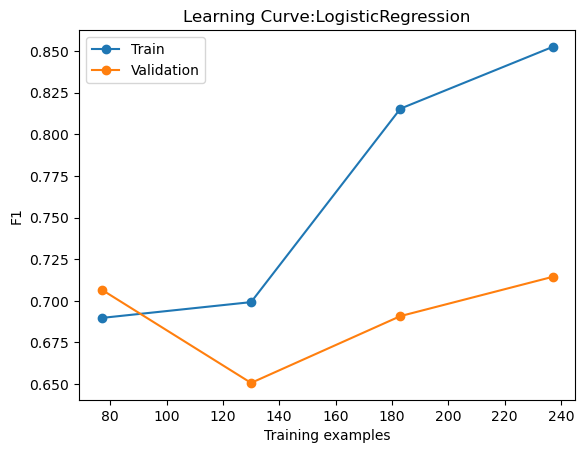

In [59]:
for name,a in modeles.items():
    train_sizes, train_scores, val_scores = learning_curve(
        a, x, y, cv=5, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)
    plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
    plt.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='Validation')
    plt.xlabel('Training examples'); plt.ylabel('F1'); plt.title(f'Learning Curve:{name}'); plt.legend(); plt.show()


In [61]:
# Save artifacts
model=RandomForestClassifier()
model.fit(x_train,y_train)
with open("heart_disease_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# save feature order
with open("feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)

print("Saved: heart_disease_model.pkl, scaler.pkl, feature_names.pkl")

Saved: heart_disease_model.pkl, scaler.pkl, feature_names.pkl
